## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib. pyplot as plt
import mne
import numpy as np
from no_wander.process import get_files_by_session, load_session_data
from pathlib import Path
from autoreject import get_rejection_threshold

mne.set_log_level('WARNING')

%matplotlib inline

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'processed'
FILE_GLOB = "*.EEG.*.csv"

session_files = get_files_by_session(DATA_DIR, FILE_GLOB)

In [4]:
FILTER_FREQ_LOW = 0.5
FILTER_FREQ_HIGH = 45

raws = []
mne_info = None
for files in list(session_files.values())[:500]:
    _, data = load_session_data(files, aux_channel=None, rename=False)
    if mne_info is None:
        mne_info = mne.create_info(
            ch_names=[col.replace('EEG_', '') for col in data.columns],
            ch_types=['eeg'] * (len(data.columns) - 1) + ['stim'],
            sfreq=256,
        )
    data = data.values.T
    data[:-1, :] *= 1e-6
    data[-1, data[-1, :] != 1] = 0
    
    raw = mne.io.RawArray(data=data, info=mne_info)
    raw.set_eeg_reference(ref_channels='average', projection=True).apply_proj()
    raw.filter(l_freq=FILTER_FREQ_LOW, h_freq=FILTER_FREQ_HIGH, picks=['eeg'], method='iir')
    raw.set_montage("standard_1005")
    raws.append(raw)
    
    del data

raw = mne.concatenate_raws(raws)

In [5]:
events = mne.find_events(raw)
epochs_kwargs=dict(
    baseline=None,
    event_id=dict(recovery=1),
    picks=mne.pick_types(raw.info, eeg=True, exclude='bads'),
    preload=True,
)
epochs = mne.Epochs(raw, events, tmin=-10, tmax=10, **epochs_kwargs)
reject = get_rejection_threshold(epochs)
epochs_kwargs['reject'] = reject

print(reject)
del epochs

Estimating rejection dictionary for eeg
{'eeg': 5.089030051567832e-05}


In [6]:
SAMPLE_SIZE_SEC = 7

def get_epochs(raw, events, tmin=0, tmax=0, **kwargs):
    event_id = dict(recovery=1)
    epochs = mne.Epochs(
        raw,
        events,
        tmax=tmax,
        tmin=tmin,
        **kwargs,
    )
    print(epochs)
    print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)
    return epochs

epochs_pre = get_epochs(raw, events, tmin=-SAMPLE_SIZE_SEC, **epochs_kwargs)
epochs_post = get_epochs(raw, events, tmax=SAMPLE_SIZE_SEC, **epochs_kwargs)

del events

<Epochs  |   673 events (all good), -7 - 0 sec, baseline off, ~36.8 MB, data loaded,
 'recovery': 673>
sample drop %:  13.273195876288657
<Epochs  |   654 events (all good), 0 - 7 sec, baseline off, ~35.8 MB, data loaded,
 'recovery': 654>
sample drop %:  15.721649484536082


# Spectrum Analysis

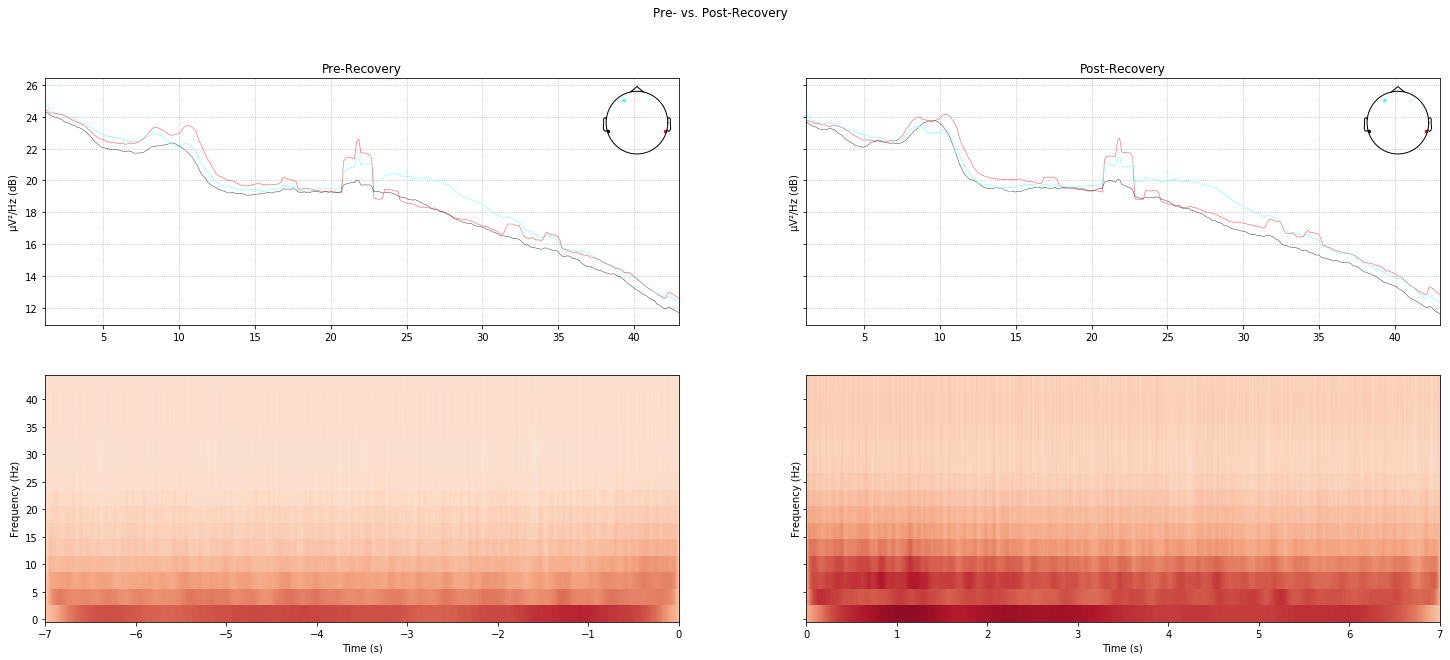

In [7]:
figsize = [25, 10]
plt.rcParams['figure.figsize'] = figsize
freqs = np.arange(1, 45, 3)

fig, axes = plt.subplots(nrows=2, ncols=2, sharey='row')
ax_pre, ax_post = axes.T
for epoch_type, epochs, ax in [('Pre', epochs_pre, ax_pre), ('Post', epochs_post, ax_post)]:
    epochs.plot_psd(freqs[0], freqs[-1], spatial_colors=True, average=False, ax=ax[0], show=False)
    ax[0].set_title(f"{epoch_type}-Recovery")
    mne.time_frequency.tfr_morlet(epochs, n_cycles=2, return_itc=False, freqs=freqs, decim=3).plot(axes=ax[1], show=False, colorbar=False)
fig.suptitle("Pre- vs. Post-Recovery")
fig.show()

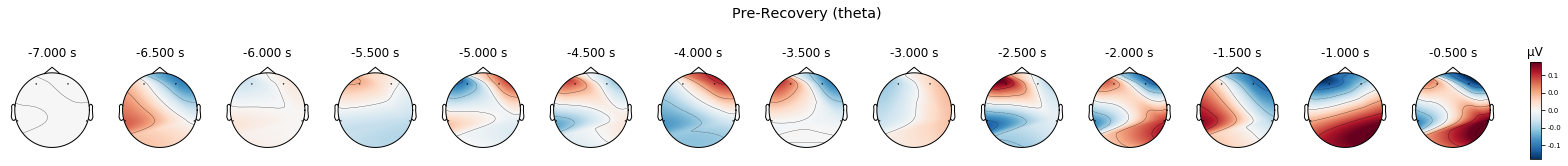

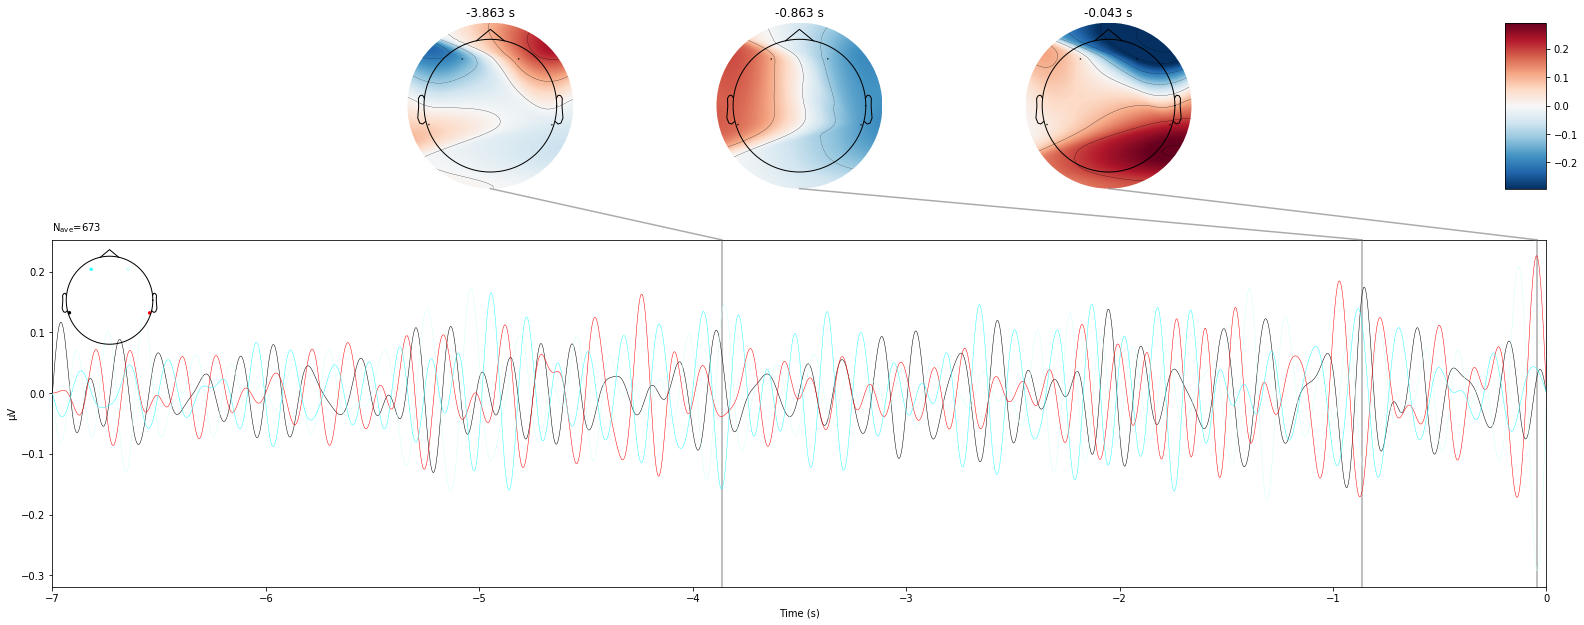

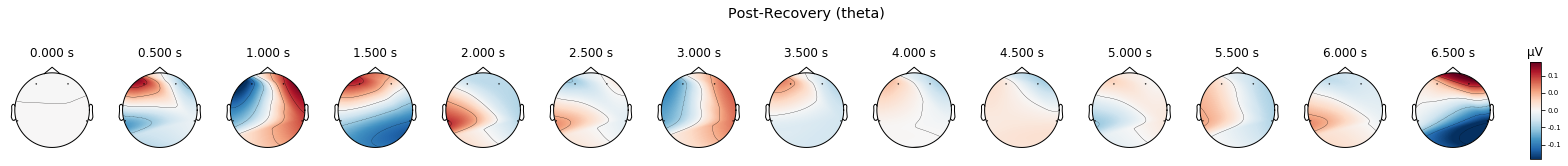

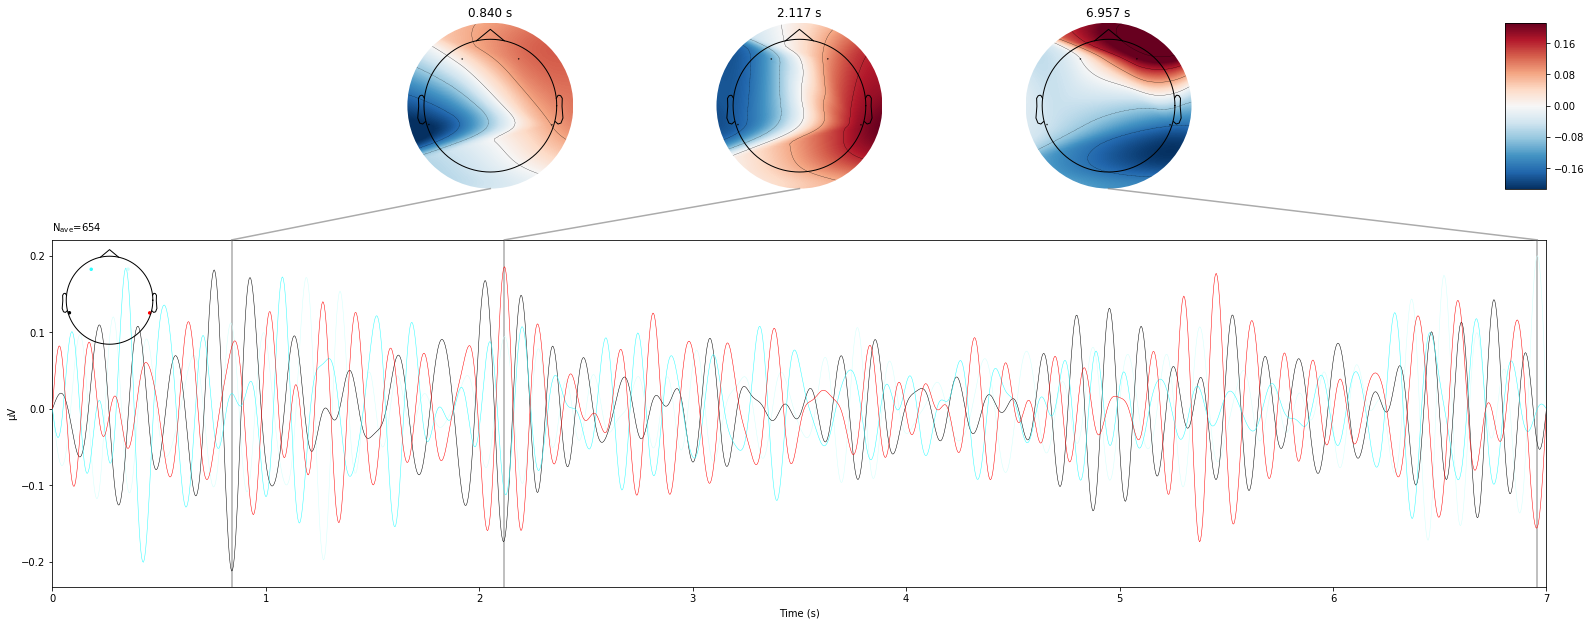

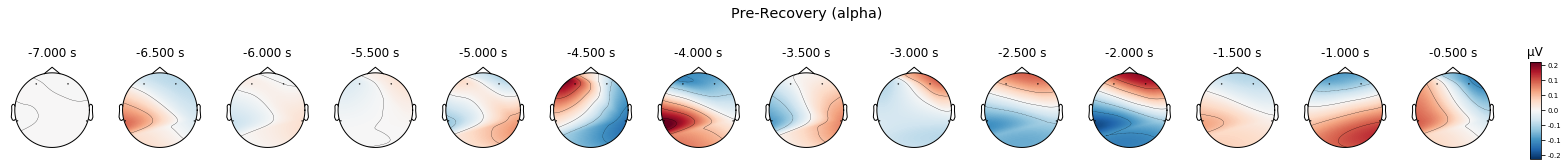

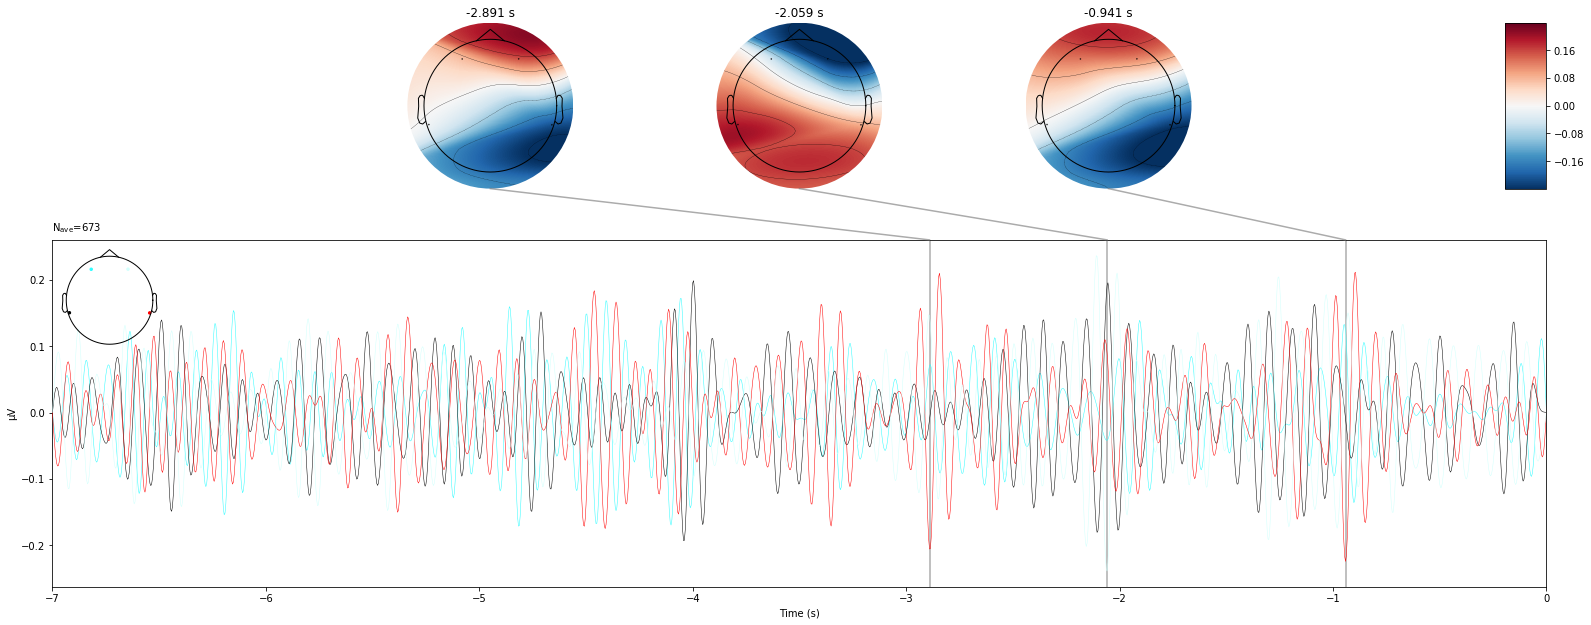

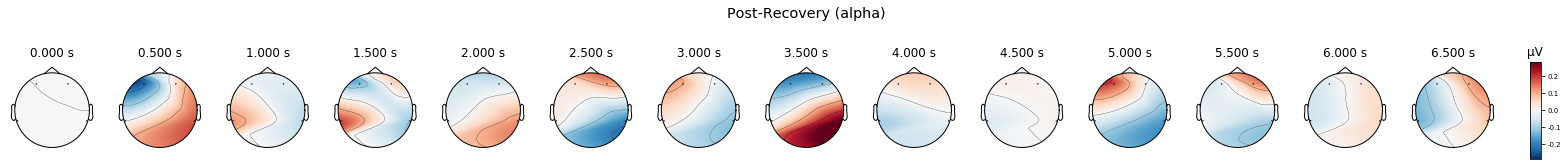

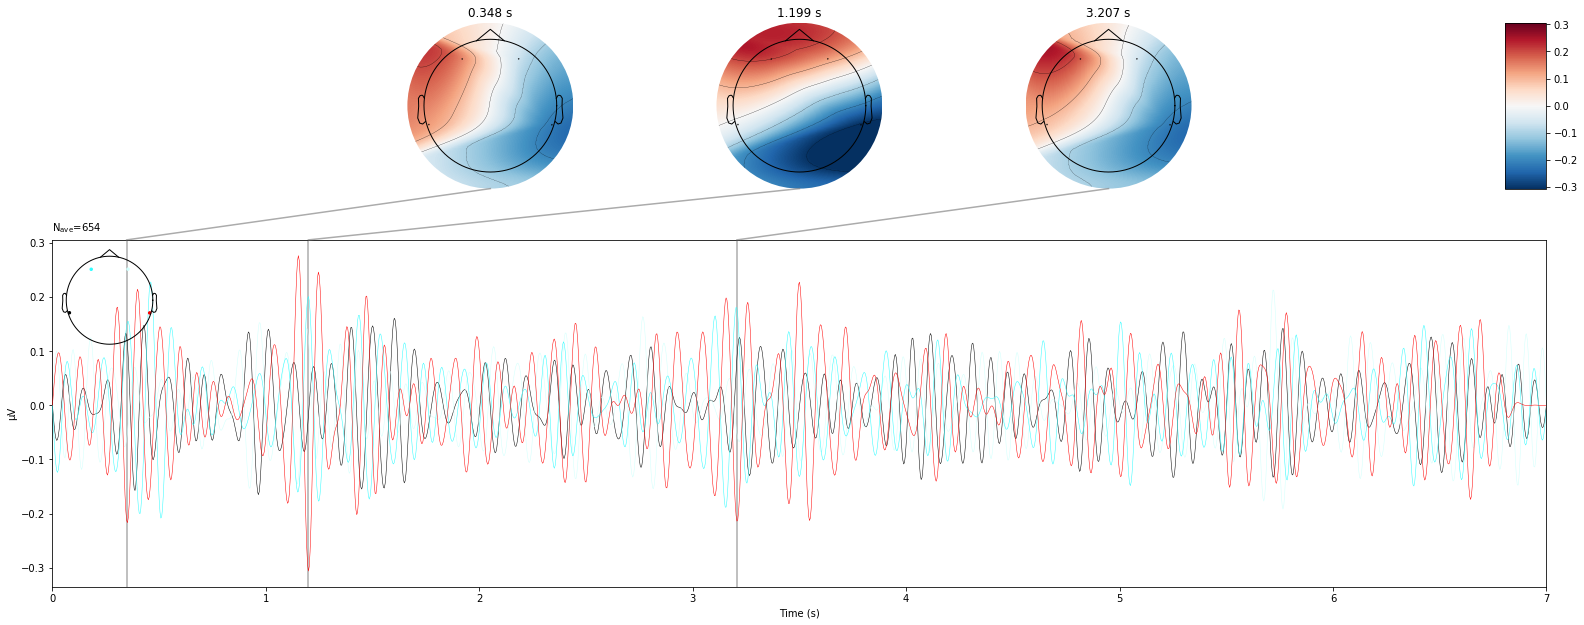

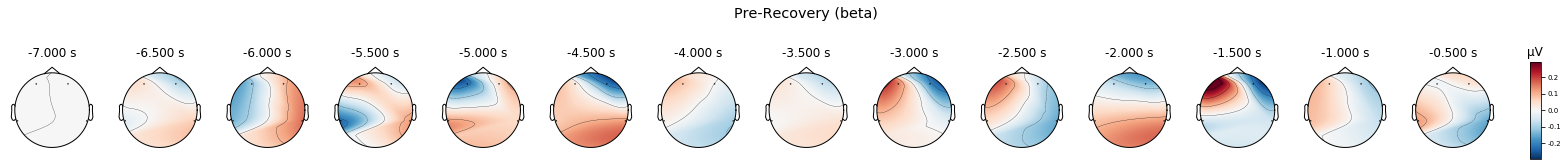

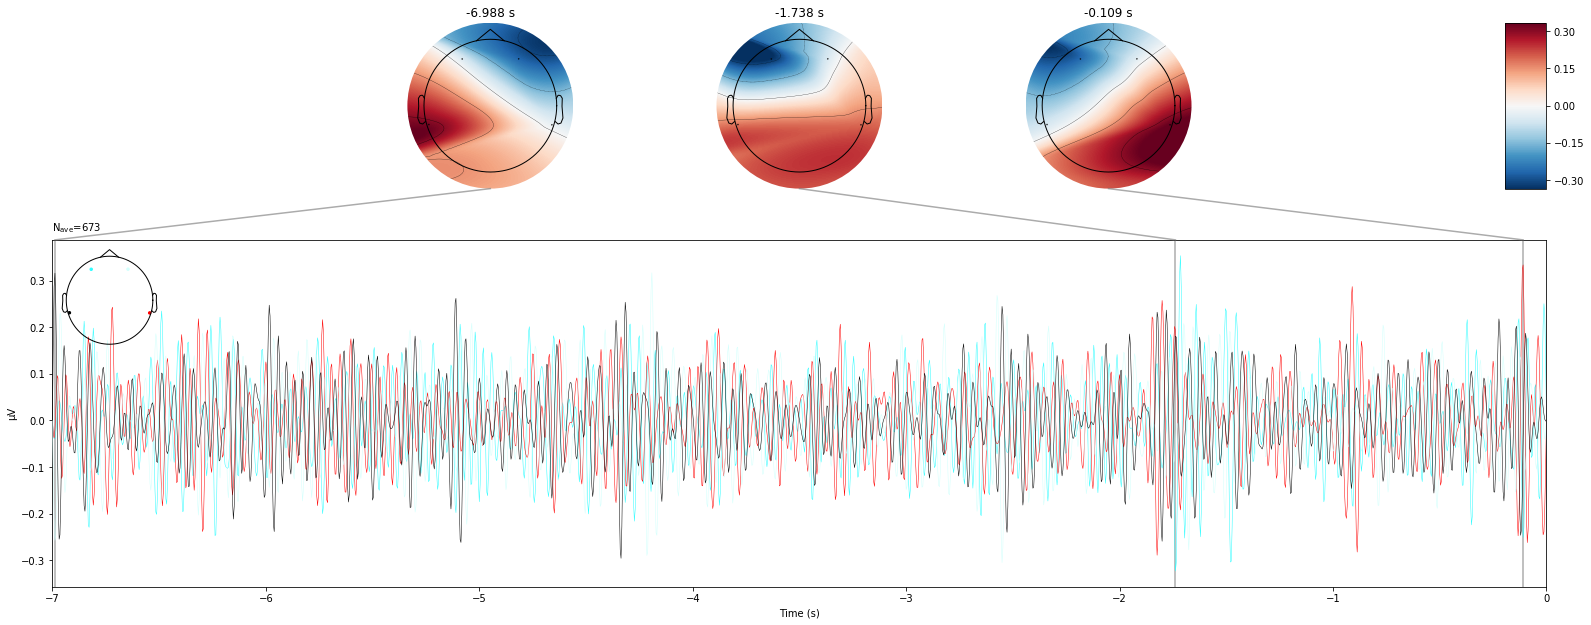

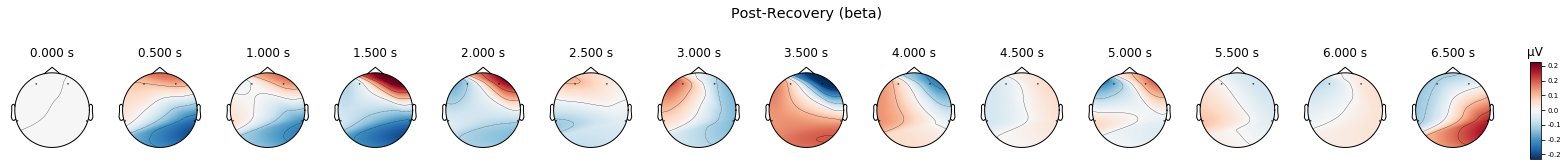

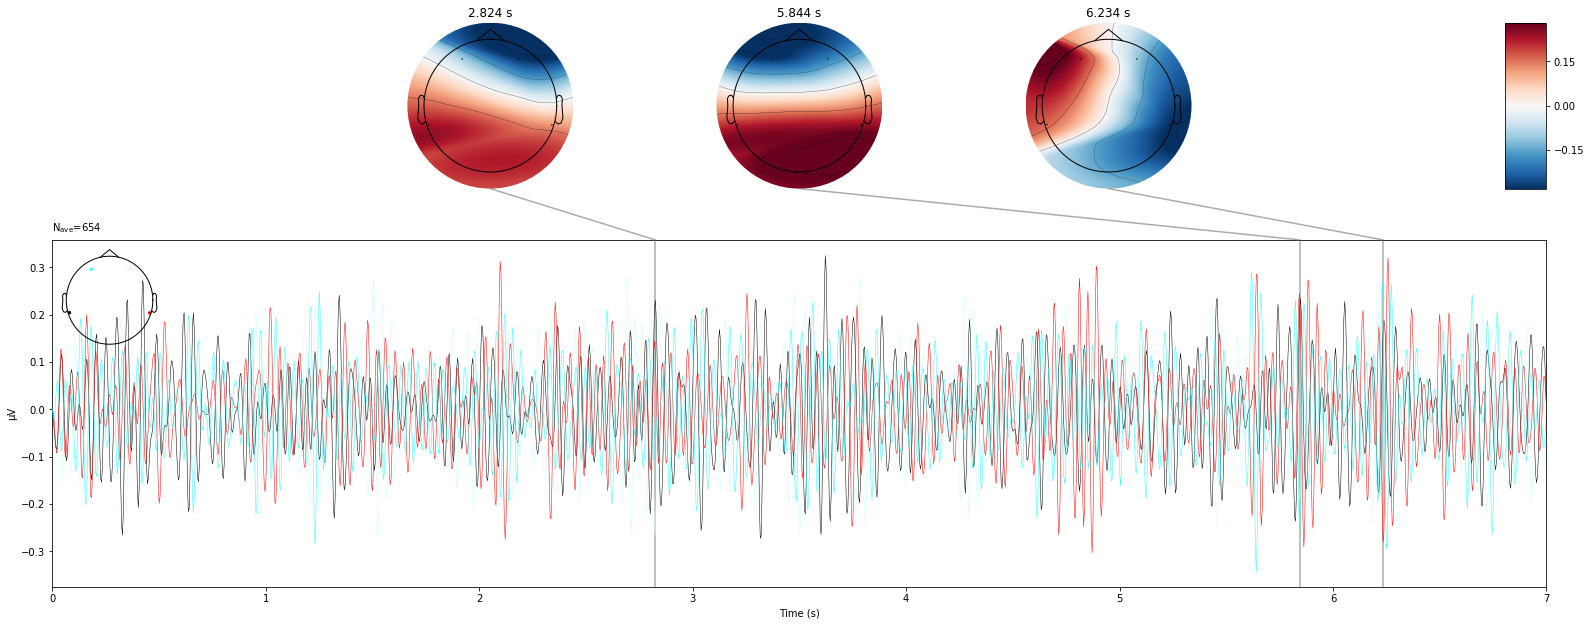

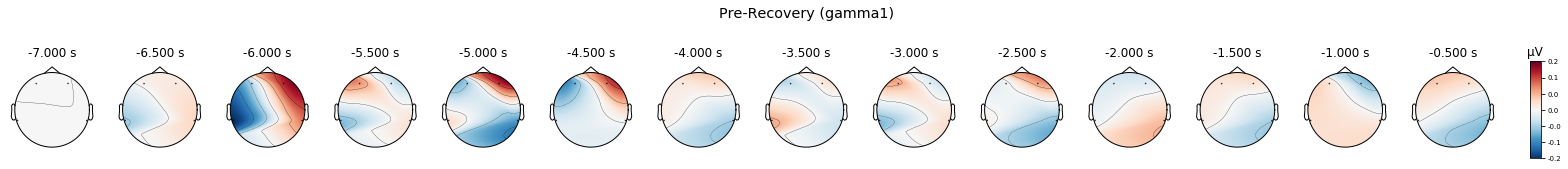

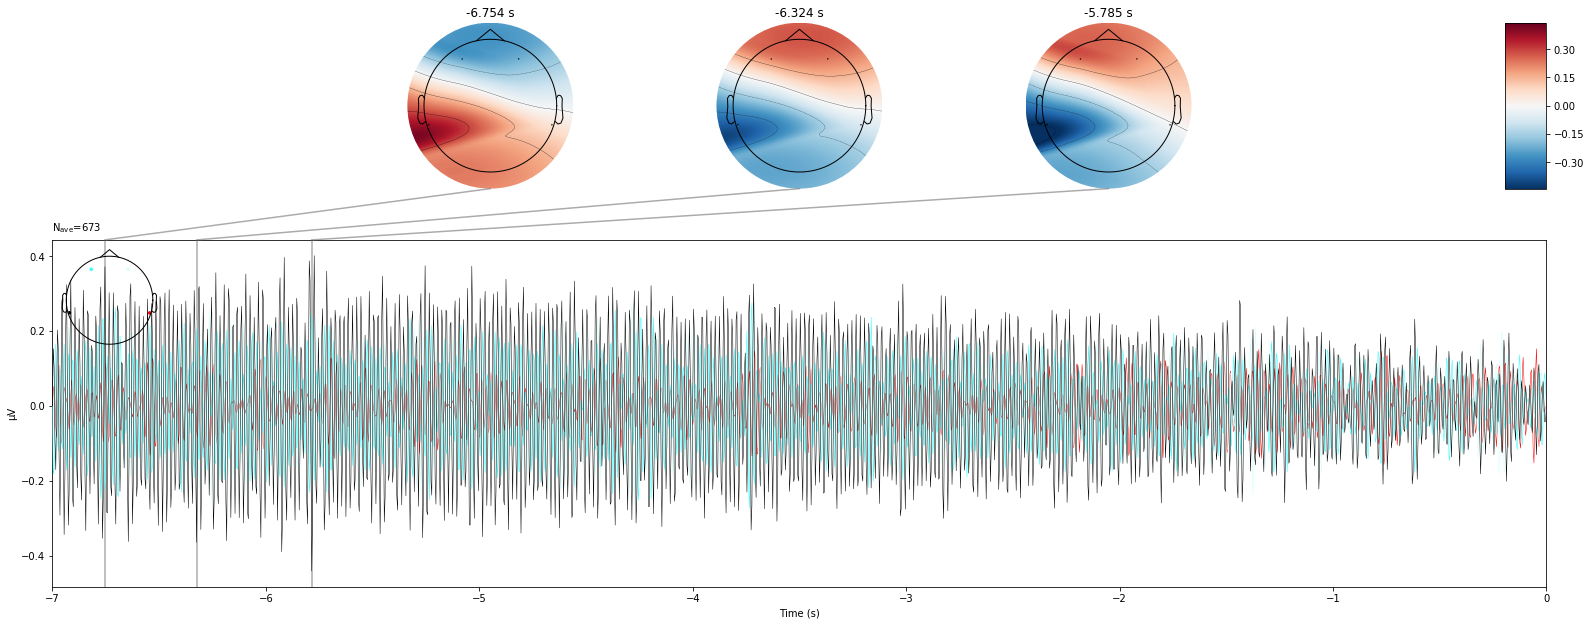

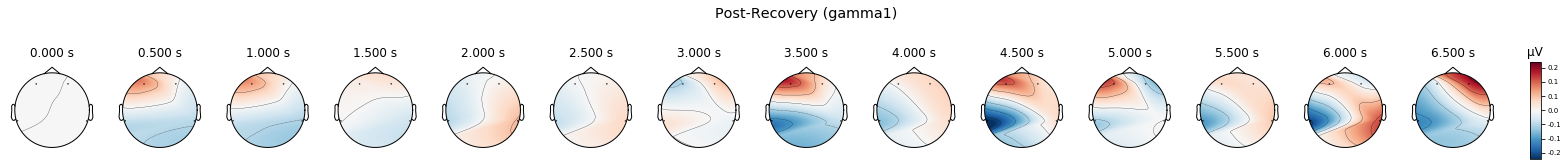

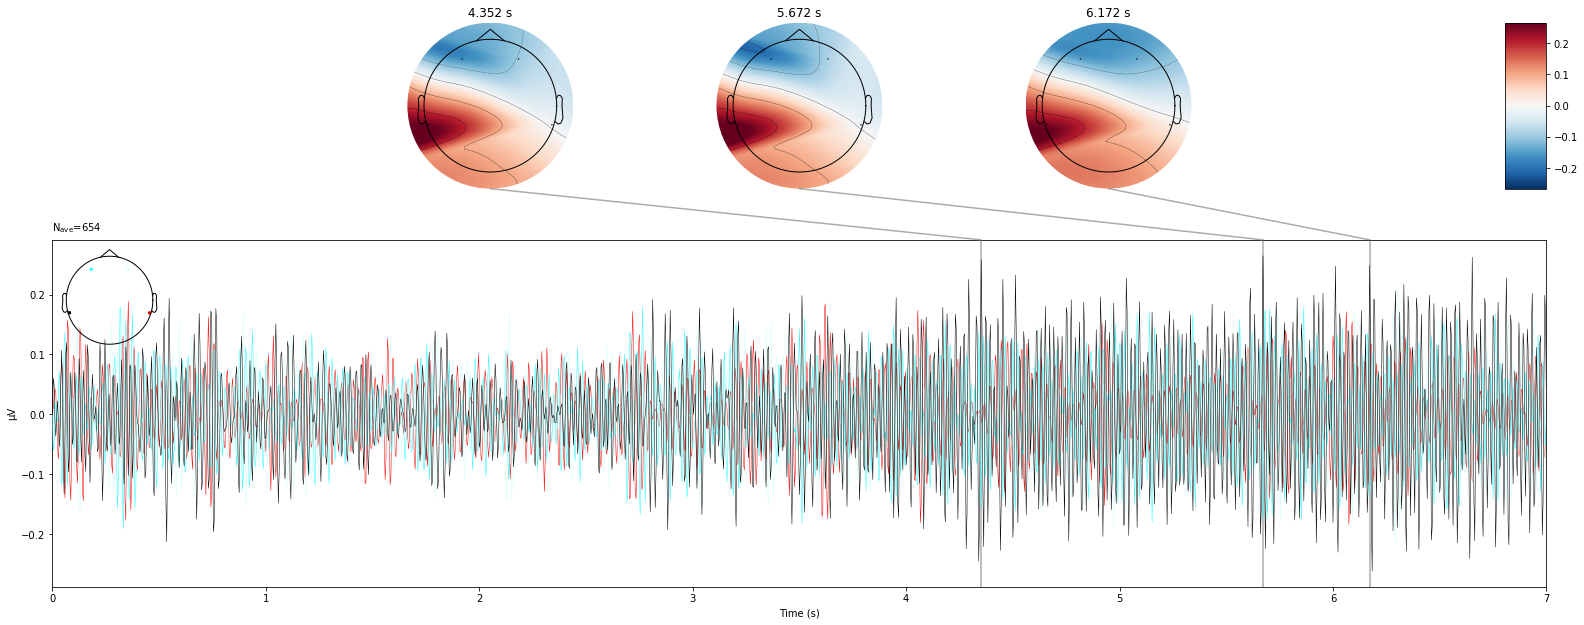

In [8]:
from no_wander.features import FREQ_BANDS

for i in range(1, len(FREQ_BANDS) - 1):
    band, freq_low = FREQ_BANDS[i]
    freq_high = None if i == len(FREQ_BANDS) - 1 else FREQ_BANDS[i + 1][1]
    for epoch_type, epochs in [('Pre', epochs_pre), ('Post', epochs_post)]:
        times = np.arange(*epochs.times[[0, -1]], 0.5)
        evoked = epochs.average().filter(freq_low, freq_high, method='iir')
        evoked.plot_topomap(title=f"{epoch_type}-Recovery ({band})", times=times)
        fig = evoked.plot_joint(title=None, show=False)
        fig.set_figwidth(figsize[0])
        fig.set_figheight(figsize[1])
        fig.show()

# Decomposition

In [9]:
raw_ica = raw.copy()
raw_ica.crop(tmax=120)
raw_ica.load_data().filter(l_freq=1., h_freq=None)

ica = mne.preprocessing.ICA(n_components=4)
ica.fit(raw_ica)

<ICA  |  raw data decomposition, fit (fastica): 30721 samples, 4 components, channels used: "eeg">

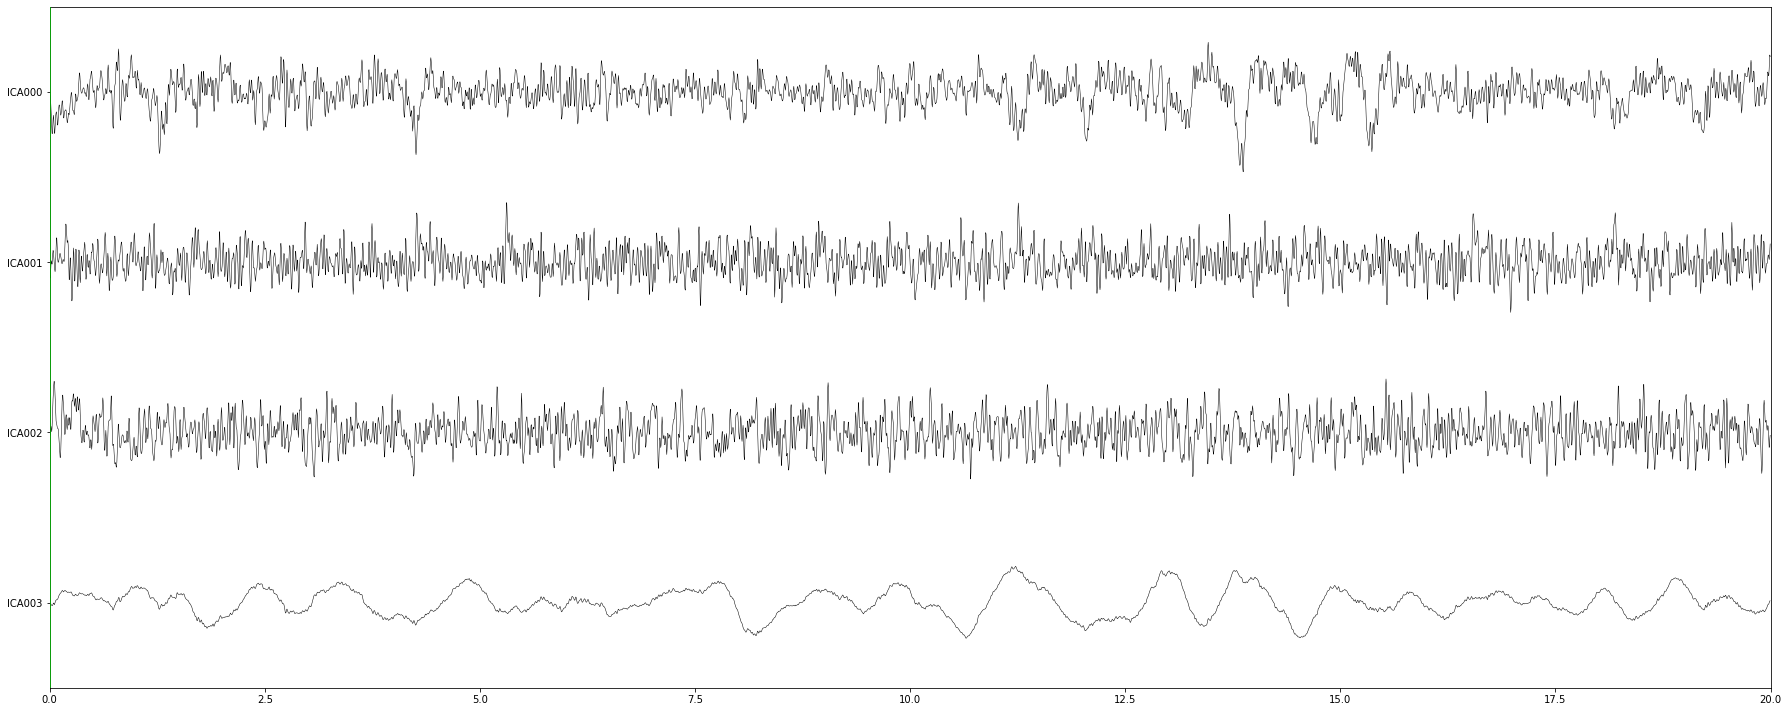

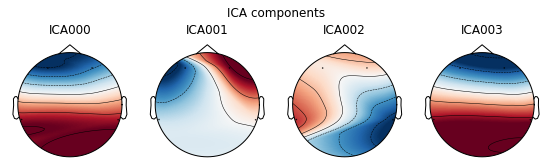

In [10]:
figsize = [25, 10]
plt.rcParams['figure.figsize'] = figsize

ica.plot_sources(raw_ica, show_scrollbars=False)
ica.plot_components()
pass

* Wavelet transform unsupervised
* Dipole
* PCA
* wavelet analysis and de-noising
* EMD/EEMD
* adaptive filtering
* N2pc ERP

# Performance Baseline: Simple Models
Attempt SVM for baseline